In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.87.134.226:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.87.134.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.134.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import numpy as np
import pandas as pd
import pickle

import gensim.models.keyedvectors as word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/MyDrive/TA/Data/Data-ANALISIS All Data Preprocessed.csv'
embedding_path = '/content/gdrive/MyDrive/TA/Embeddings/glove_wikiid.txt'
#best_model_path = "/content/gdrive/MyDrive/TA/Result/Model/210806-Data-W2V-WikiID.h5"
#oosDF_path = '/content/gdrive/MyDrive/TA/Result/10806-Data-W2V-WikiID.csv'
#hist_path = '/content/gdrive/MyDrive/TA/Result/Train History/thd-210806-Data-W2V-WikiID'

#Data Preparation

In [ ]:
DATA = pd.read_csv(data_path, sep=',')
print(DATA.shape)
print(DATA['Sentimen'].value_counts())
DATA.head()

(3000, 10)
neg    1050
pos    1050
net     900
Name: Sentimen, dtype: int64


,Unnamed: 0,username,Sentimen,tweet,tokens,tokens_stopwords_removal,tokens_stem,tokens_merged,tokens_sr_merged,tokens_stem_merged
0,0,scarletlilyyy,pos,gak sempat bacaa itu kenapa suka banget make d...,"['enggak', 'sempat', 'bacaa', 'itu', 'kenapa',...","['bacaa', 'suka', 'banget', 'memakai', 'dana']","['enggak', 'sempat', 'bacaa', 'itu', 'kenapa',...",enggak sempat bacaa itu kenapa suka banget pak...,bacaa suka banget memakai dana,enggak sempat bacaa itu kenapa suka banget pak...
1,1,prad_prat,pos,dana meskipun kamu gini sekarang cashback mu d...,"['dana', 'meski', 'kamu', 'begini', 'sekarang'...","['dana', 'cashback', 'mu', 'tak akan', 'ku', '...","['dana', 'meski', 'kamu', 'begini', 'sekarang'...",dana meski kamu begini sekarang cashback mu du...,dana cashback mu tak akan ku lupakan cashback ...,dana meski kamu begini sekarang cashback mu du...
2,2,abcdefucekme45,pos,udh trlanjur nyaman sma krna promo di murah tr...,"['sudah', 'trlanjur', 'nyaman', 'sama', 'karen...","['trlanjur', 'nyaman', 'promo', 'murah', 'tari...","['sudah', 'trlanjur', 'nyaman', 'sama', 'karen...",sudah trlanjur nyaman sama karena promo di mur...,trlanjur nyaman promo murah tarikkirim uang ga...,sudah trlanjur nyaman sama karena promo di mur...
3,3,svtnvisual,pos,shim mjb gue pake dana buat transfer beda bank...,"['shim', 'mjb', 'saya', 'pakai', 'dana', 'buat...","['shim', 'mjb', 'pakai', 'dana', 'transfer', '...","['shim', 'mjb', 'saya', 'pakai', 'dana', 'buat...",shim mjb saya pakai dana buat transfer beda ba...,shim mjb pakai dana transfer beda bank doang g...,shim mjb saya pakai dana buat transfer beda ba...
4,4,danettama,pos,aman banget nderrrr temenku ada yang udah nyob...,"['aman', 'banget', 'nder', 'teman', 'ada', 'ya...","['aman', 'banget', 'nder', 'temanku', 'mencoba...","['aman', 'banget', 'nder', 'teman', 'ada', 'ya...",aman banget nder teman ada yang sudah coba jug...,aman banget nder temanku mencoba niatnya menco...,aman banget nder teman ada yang sudah coba jug...


#Train

In [ ]:
sentiment = list(DATA['Sentimen'])

In [ ]:
DATA['tokens_sr_merged'] = DATA['tokens_sr_merged'].astype(str)
tweets = list(DATA['tokens_sr_merged'])

In [ ]:
y = []
for i in range(len(sentiment)):
  if (sentiment[i] == "pos"):
    y.append(1)
  elif (sentiment[i] == "neg"):
    y.append(0)
  else:
    y.append(2)
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
pos = DATA[DATA['Sentimen'] == 'pos']
neg = DATA[DATA['Sentimen'] == 'neg']
net = DATA[DATA['Sentimen'] == 'net']
concated = pd.concat([pos, neg, net], ignore_index=True)
concated['LABEL'] = 0

In [ ]:
#One-hot encode the lab
concated.loc[concated['Sentimen'] == 'neg', 'LABEL'] = 0
concated.loc[concated['Sentimen'] == 'pos', 'LABEL'] = 1
concated.loc[concated['Sentimen'] == 'net', 'LABEL'] = 2
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=3)
print(labels[:10])
if 'Sentimen' in concated.keys():
    concated.drop(['Sentimen'], axis=1)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: LABEL, dtype: int64
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
all_text = []
for i in (DATA['tokens_sr_merged']):
  all_text.append(i)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
X = tokenizer.texts_to_sequences(all_text)

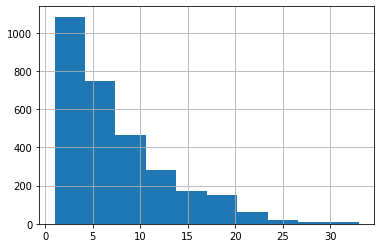

count    3000.000000
mean        7.617000
std         5.389743
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        33.000000
dtype: float64

In [ ]:
%matplotlib inline
tweets_len = [len(x) for x in X]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

**CEK MAX LENGTHNYA!!!**

In [ ]:
#lenght of tweet to consider
maxlentweet = 20
#add padding
X = pad_sequences(X, maxlen=maxlentweet)
print(X.shape)

(3000, 20)


In [ ]:
final_acc_dict = {} #key:epoch value:final acc of k-fold
for epochs in range(10,21,1):
  print("Epoch : ", epochs)
  print("======================")

  param = "Glove Param 4_Epoch "
  best_model_path = "/content/gdrive/MyDrive/TA/Result/Model/Param 4/"+param+str(epochs)+".h5"
  oosDF_path = "/content/gdrive/MyDrive/TA/Result/Param 4/"+param+str(epochs)+'.csv'
  hist_path = "/content/gdrive/MyDrive/TA/Result/Train History/Param 4/"+param+str(epochs)

  tmp_file = get_tmpfile("w2v_format.txt")

  glove2word2vec(embedding_path, tmp_file)
  w2vModel = word2vec.KeyedVectors.load_word2vec_format(tmp_file, binary=False)

  #create a embedding layer using word embedding, trainable is optional
  embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], 
                              output_dim=w2vModel.syn0.shape[1], 
                              weights=[w2vModel.syn0], 
                              input_length=X.shape[1], 
                              trainable=True)

  # Cross-validate
  # Use for StratifiedKFold classification
  kf = StratifiedKFold(10, shuffle=True, random_state=42)
      
  oos_y = []
  oos_pred = []
  combined_df = []
  fold = 0
  hist_dict = {}
  #autosave best Model
  best_model_file = best_model_path
  best_model = [ModelCheckpoint(best_model_file, 
                                monitor='val_accuracy', 
                                verbose=0, 
                                save_best_only=True)]

  # Must specify y StratifiedKFold for
  for train, test in kf.split(X,y):
    print(f"Fold #{fold+1}")
        
    x_train = X[train]
    y_train = labels[train]
    x_test = X[test]
    y_test = labels[test]
    sliced_df = DATA.iloc[test].copy()

    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(units=100, dropout=0.5, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    #epochs = 10
    batch_size = 32
    hist = model.fit(x_train, y_train, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test,y_test),
                    verbose=0, callbacks=best_model)

    pred = model.predict(x_test)

    oos_y.append(y_test)
    # raw probabilities to chosen class (highest probability)
    pred = np.argmax(pred,axis=1) 
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    #print(f"Fold score (accuracy): {score}")
    hist_dict[fold] = hist.history
    combined_df.append(sliced_df)
    fold += 1

  # Build the oos prediction list and calculate the error.
  oos_y = np.concatenate(oos_y)
  oos_pred = np.concatenate(oos_pred)
  oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

  score = metrics.accuracy_score(oos_y_compare, oos_pred)
  print(f"Final score (accuracy): {score}")
  final_acc_dict[epochs] = score
      
  # Write the cross-validated prediction
  combined_df = pd.concat(combined_df, ignore_index=True)
  oos_y = pd.DataFrame(oos_y)
  oos_pred = pd.DataFrame(oos_pred)
  oosDF = pd.concat( [combined_df, oos_y, oos_pred],axis=1)
  oosDF.rename(columns={'Unnamed: 0':'Actual index'}, inplace=True)

  oosDF.to_csv(oosDF_path,index=False)
  with open(hist_path, 'wb') as file_pi:
    pickle.dump(hist_dict, file_pi)

Epoch :  10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.8696666666666667
Epoch :  11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.8713333333333333
Epoch :  12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.8793333333333333
Epoch :  13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.877
Epoch :  14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.8783333333333333
Epoch :  15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.88
Epoch :  16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.8843333333333333
Epoch :  17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.8856666666666667
Epoch :  18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.887
Epoch :  19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.888
Epoch :  20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Fold #1
Fold #2
Fold #3
Fold #4
Fold #5
Fold #6
Fold #7
Fold #8
Fold #9
Fold #10
Final score (accuracy): 0.884


In [ ]:
import json

with open('/content/gdrive/MyDrive/TA/Result/Param 4/Epoch experiment dict_glove_param4.json', 'w') as fp:
    json.dump(final_acc_dict, fp)